Notebook on learning R, \gamma and p simultaneously using Environment Design

In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

from src.utils.inference.sampling import get_parameter_sample, bayesian_parameter_learning
from src.utils.make_environment import transition_matrix, get_candidate_environments, Environment, insert_walls_into_T
from src.utils.environment_design import environment_search
from src.utils.visualization import plot_posterior_distribution, plot_environment, plot_trajectories
from src.utils.constants import ParamTuple, beta_agent
from src.utils.optimization import soft_q_iteration
from src.utils.inference.rollouts import generate_n_trajectories
from src.experimental.inference.sampling import exp_bayesian_parameter_learning

np.set_printoptions(linewidth=160, precision=2)

Create Environment

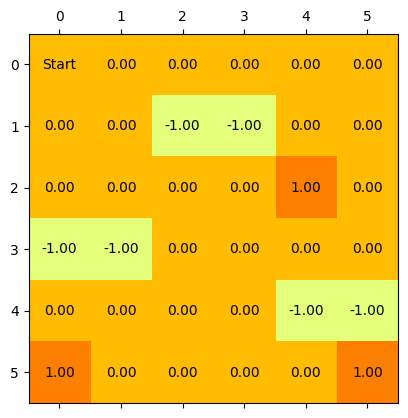

In [3]:
# 0. Setup
## 0.1 Setup the experiment
n_env_samples = 15
n_posterior_samples = 10
n_traj_per_sample = 2

## 0.2 Setup the environment
N, M = 6, 6
n_states, n_actions = N * M, 4

# Create a type of BigSmall world with a dangerous zone
R_true = np.zeros((N, M))
R_true[-1, 0] = 1
R_true[-1, -1] = 1
R_true[2, 4] = 1
R_true[1, 2] = -1
R_true[1, 3] = -1
R_true[3, 0] = -1
R_true[3, 1] = -1
R_true[4, 4] = -1
R_true[4, 5] = -1
R_true = R_true.flatten()

goal_states = np.where(R_true != 0)[0]

plot_environment(
    R_true.reshape(N, M),
    [])

## Prior sampling


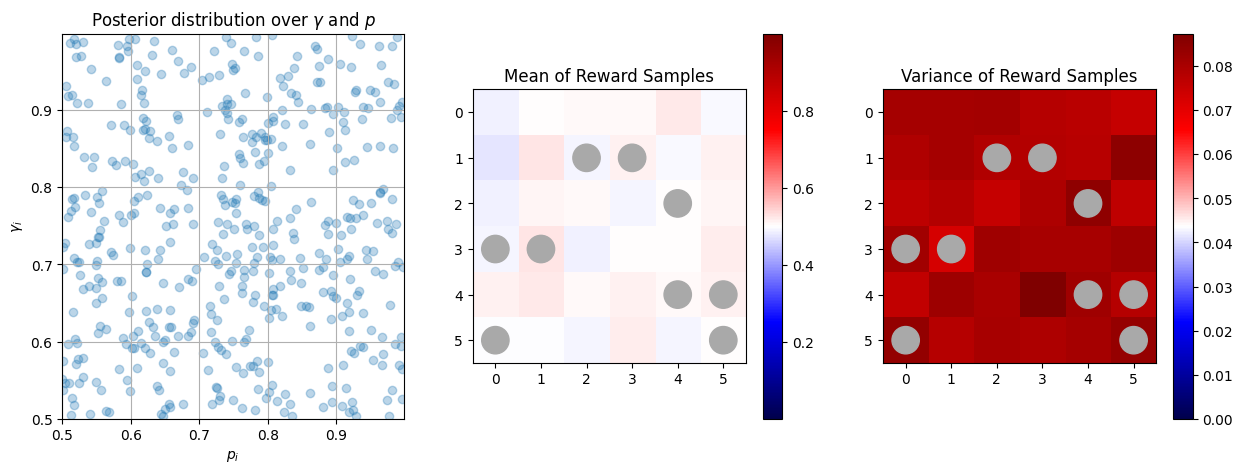

In [4]:
posterior_samples_0 = bayesian_parameter_learning(expert_trajectories=[], 
                                                  sample_size=1000, 
                                                  goal_states=goal_states, 
                                                  n_states=n_states)

plot_posterior_distribution(posterior_samples=posterior_samples_0[:500], N=N, M=M, absorbing_states=goal_states)

#### Start by finding an environment to generate initial trajectories from


#### Create the unknown true agent and trajectories in the chosen environment


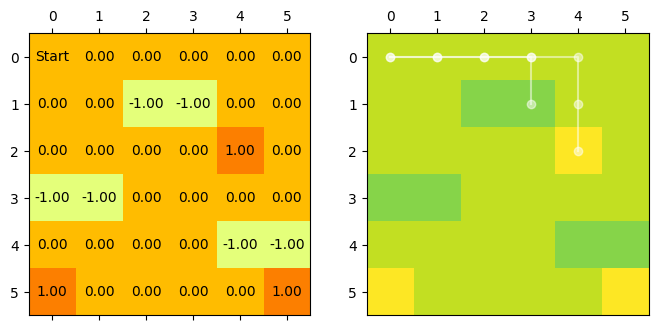

In [5]:
# Start by making the agent we want to learn the policy of
agent_p = 0.9
agent_gamma = 0.9
agent_R = R_true
p_true=0.999

agent_R = agent_R.flatten()
goal_states = np.where(agent_R != 0)[0]

true_params = ParamTuple(agent_p, agent_gamma, agent_R)


# Generate 2 trajectories in the env starting environment
wall_states = []
T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T_agent, wall_indices=wall_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=beta_agent)

env_agent = Environment(N=N,M=M,T_true=T_true,wall_states=wall_states, R_sample_mean=None, start_state=0, n_walls=None)

# Generate trajectories
trajectories = generate_n_trajectories(
    T_agent,
    agent_policy,
    goal_states,
    n_trajectories=2,
)

expert_trajectories = [(env_agent, trajectories)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent.wall_states,
    start_state=(env_agent.start_state // M, env_agent.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

#### Sample from the posterior under these trajectories


In [6]:
# Sample from posterior
posterior_samples_1 = bayesian_parameter_learning(
    expert_trajectories=expert_trajectories, sample_size=1_000, goal_states=goal_states, n_states=n_states
)

# Keep the last 10_000 of samples
posterior_samples_1 = posterior_samples_1[-250:]
# Plot the posterior distribution

Posterior sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Posterior sampling:  21%|██        | 206/1000 [00:04<00:28, 27.99it/s, Acceptance rate=25.1, step_size=0.18]/home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/src/utils/inference/likelihood.py:16: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(T[s, a, next_s] * policy[s, a])


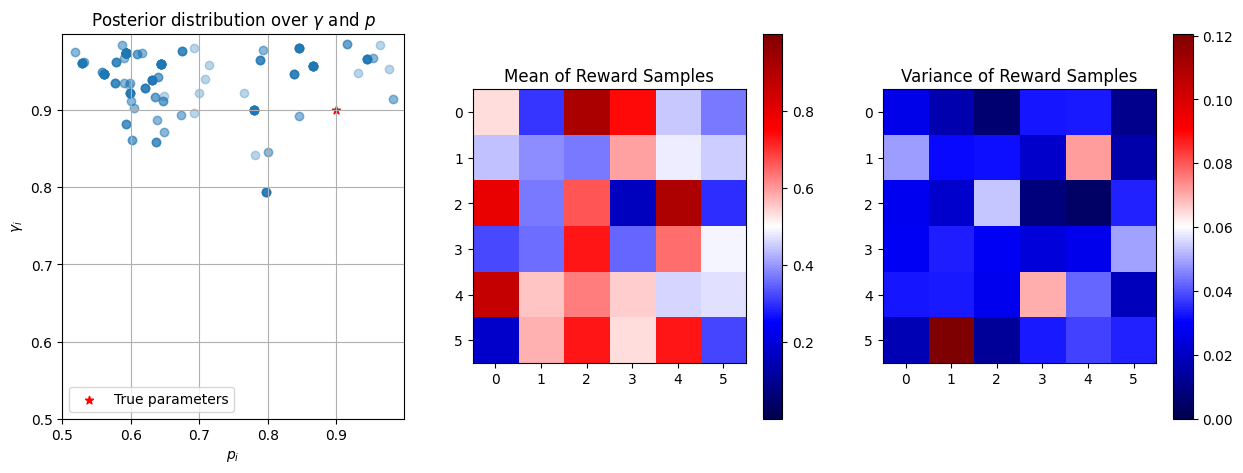

In [7]:
plot_posterior_distribution(posterior_samples_1,N,M,true_params = ParamTuple(p = agent_p, gamma = agent_gamma, R = None))

#### Start round two, maximize regret with the new posterior


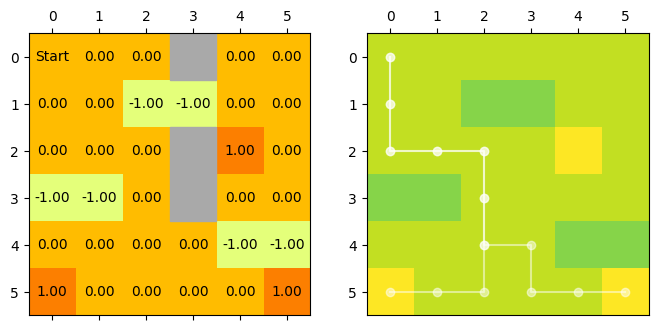

In [8]:
# Sample a subset of the posterior samples
sample_idxs = np.random.choice(
    np.arange(len(posterior_samples_1)), size=100, replace=False
)
samples = [posterior_samples_1[i] for i in sample_idxs]

# Generate 2 trajectories in the second round environment
wall_states = [3, 15, 21]
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T_agent, wall_indices=wall_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=beta_agent)

env_agent_2 = Environment(N=N,M=M,T_true=T_true,wall_states=wall_states, R_sample_mean=None, start_state=0, n_walls=None)

# Generate trajectories
trajectories_2 = generate_n_trajectories(
    T_agent,
    agent_policy,
    goal_states,
    n_trajectories=2,
)

expert_trajectories.append([env_agent_2, trajectories_2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent_2.wall_states,
    start_state=(env_agent.start_state // M, env_agent.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories_2, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

Posterior sampling:   0%|          | 0/1000 [00:00<?, ?it/s]/home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/src/utils/inference/sampling.py:114: RuntimeWarning: invalid value encountered in scalar divide
  quotient = p / p_old
Posterior sampling:   0%|          | 0/1000 [00:00<?, ?it/s, Acceptance rate=0, step_size=0.09]/home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/src/utils/inference/sampling.py:114: RuntimeWarning: divide by zero encountered in scalar divide
  quotient = p / p_old
Posterior sampling:   2%|▏         | 19/1000 [00:00<00:24, 40.59it/s, Acceptance rate=17.4, step_size=0.19]/home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/src/utils/inference/likelihood.py:16: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(T[s, a, next_s] * policy[s, a])


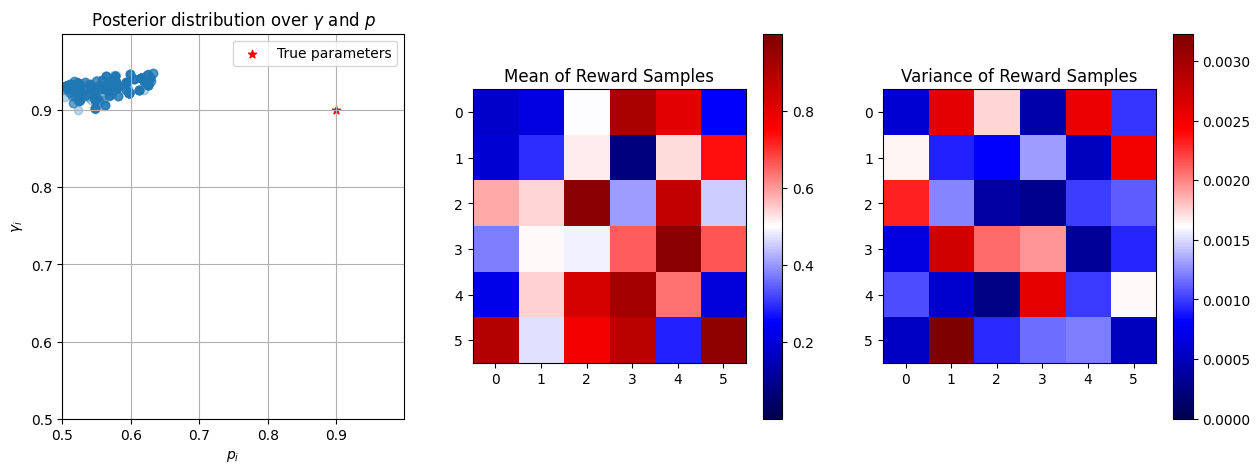

In [26]:
# Sample from posterior
posterior_samples_2 = bayesian_parameter_learning(
    expert_trajectories, 1_000, goal_states = goal_states, n_states = n_states
)

# Keep the last 500 of samples
posterior_samples_2 = posterior_samples_2[500:]
# Plot the posterior distribution
plot_posterior_distribution(posterior_samples_2, N=N, M=M, true_params=true_params)

#### Start round three, maximize regret with the new posterior


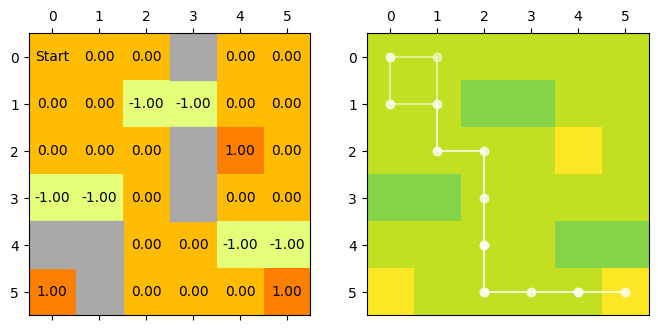

In [11]:
# Sample a subset of the posterior samples
sample_idxs = np.random.choice(
    np.arange(len(posterior_samples_1)), size=100, replace=False
)
samples = [posterior_samples_1[i] for i in sample_idxs]

# Generate 2 trajectories in the second round environment
wall_states = [3, 15, 21, 24, 25, 31]
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T_agent, wall_indices=wall_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=20.0)

env_agent_3 = Environment(N=N,M=M,T_true=T_true,wall_states=wall_states, R_sample_mean=None, start_state=0, n_walls=None)

# Generate trajectories
trajectories_3 = generate_n_trajectories(
    T_agent,
    agent_policy,
    goal_states,
    n_trajectories=2,
)

expert_trajectories.append([env_agent_3, trajectories_3])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent_3.wall_states,
    start_state=(env_agent.start_state // M, env_agent.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories_3, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

In [46]:
# Sample from posterior
posterior_samples_3 = bayesian_parameter_learning(
    expert_trajectories, 5_000, goal_states = goal_states, n_states = n_states, previous_sample=true_params
)

# Keep the last 500 of samples
# posterior_samples_3 = posterior_samples_3[-500:]
# Plot the posterior distribution
# plot_posterior_distribution(posterior_samples_3, N=N, M=M, true_params=true_params)

Posterior sampling:  32%|███▏      | 1597/5000 [01:10<04:42, 12.05it/s, Acceptance rate=21.2, step_size=0.04]/home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/src/utils/inference/likelihood.py:16: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(T[s, a, next_s] * policy[s, a])


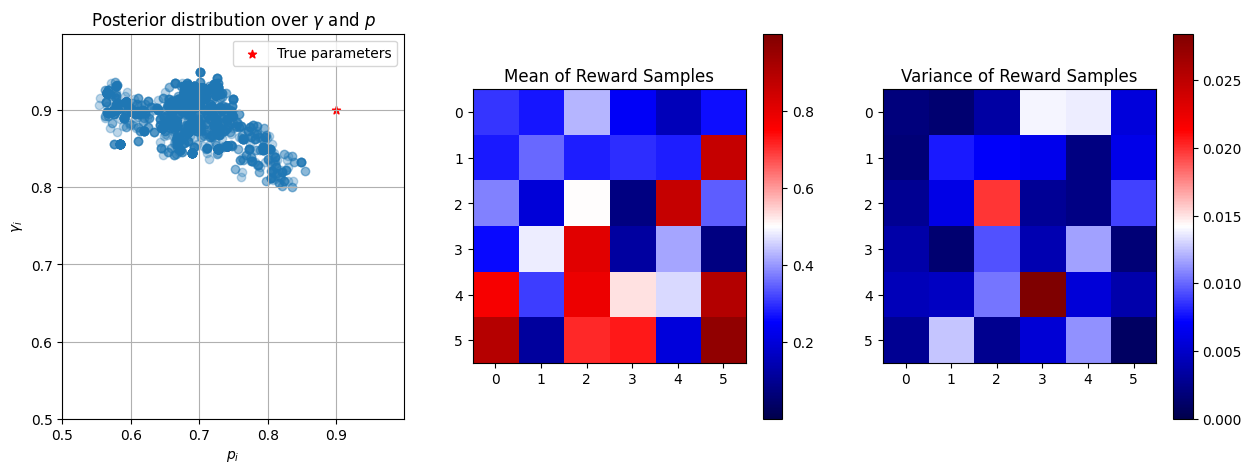

In [47]:
plot_posterior_distribution(posterior_samples_3[2500:], N=N, M=M, true_params=true_params)

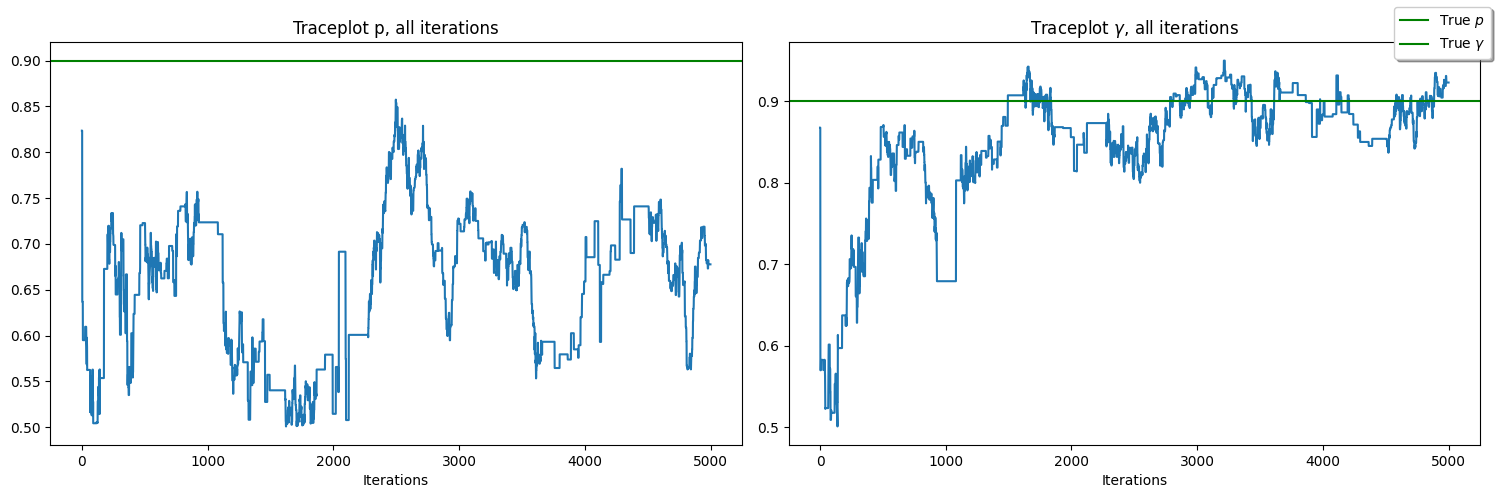

In [54]:
samples_p = [sample[0] for sample in posterior_samples_3]
samples_gamma = [sample[1] for sample in posterior_samples_3]
samples_R = [sample[2] for sample in posterior_samples_3]

n_burnin:int = 2500

fig, axs = plt.subplots(1,2, figsize = (15,5))
axs[0].plot(samples_p)
axs[0].set_title("Traceplot p, all iterations")
axs[0].set_xlabel("Iterations")
axs[0].axhline(agent_p, label = "True $p$", c="green")


axs[1].plot(samples_gamma)
axs[1].set_title("Traceplot $\gamma$, all iterations")
axs[1].set_xlabel("Iterations")
axs[1].axhline(agent_gamma, label = "True $\gamma$", c="green")


fig.legend(loc="upper right", fancybox=True, shadow=True)
fig.tight_layout()